<a href="https://colab.research.google.com/github/Satyam1Gupta/Brrrgrr_frontend/blob/main/SentimentAnalysis_with_FastText_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting the environment

In [1]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


## Loading dataset

In [2]:

twitter_data = pd.read_excel("/content/Final_balanced_sentiment_data.xlsx")

twitter_data

,text,sentiment
0,what did just say vote for modi welcome bjp t...,1
1,asking his supporters prefix chowkidar their n...,1
2,answer who among these the most powerful world...,1
3,with upcoming election india saga going import...,1
4,gandhi was gay does modi,1
...,...,...
131356,what modi saying against democracy should flee...,0
131357,niti aayog accessory for the modi government m...,0
131358,mrjairam here answer lies bjp godi media many ...,0
131359,india prime ministerasaduddin owaisi slams mod...,0


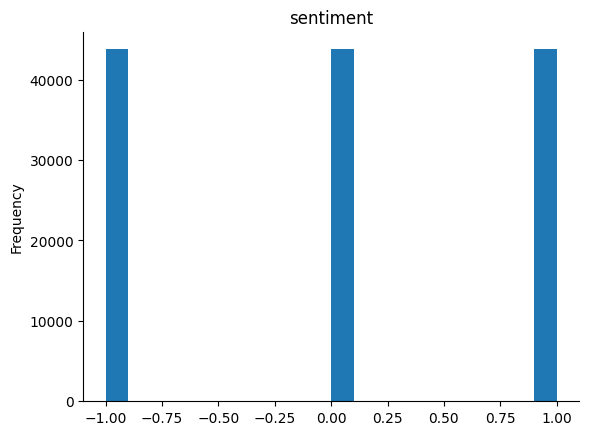

In [3]:
from matplotlib import pyplot as plt
twitter_data['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Dataset exploration

twitter_data.shape

(131361, 2)

In [6]:
twitter_data.head(5)

,text,sentiment
0,what did just say vote for modi welcome bjp t...,1
1,asking his supporters prefix chowkidar their n...,1
2,answer who among these the most powerful world...,1
3,with upcoming election india saga going import...,1
4,gandhi was gay does modi,1


In [7]:
# Checking for missing values

twitter_data.isnull().values.sum()

2

In [8]:
# Delete rows with any null values
twitter_data = twitter_data.dropna()

# Verify that there are no missing values left
missing_values_cleaned = twitter_data.isnull().sum()
print(missing_values_cleaned)

text         0
sentiment    0
dtype: int64


<Axes: xlabel='sentiment', ylabel='count'>

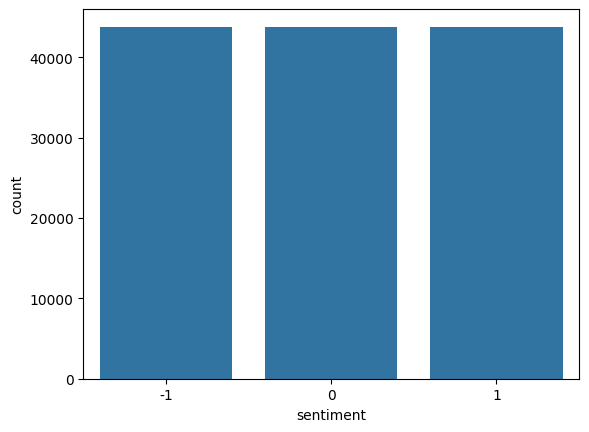

In [9]:
# Let's observe distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='sentiment', data=twitter_data)

## Data Preprocessing

In [10]:
twitter_data["text"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'answer who among these the most powerful world leader today trump putin modi may '

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    sentence=sen
    # sentence = sen.lower()

    # # Remove html tags
    # sentence = remove_tags(sentence)

    # # Remove punctuations and numbers
    # sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
# Calling preprocessing_text function on twitter_data

X = []
sentences = list(twitter_data['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'answer among powerful world leader today trump putin modi may '

In [15]:
# Converting sentiment labels to 0 & 1

y = twitter_data['sentiment']

# y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

## Preparing embedding layer

*Embedding* layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [17]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [18]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

88154

In [19]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [20]:
# #Donwlnload word to vec word embeddings to create an embeddign dict. and Instead of using wordtovec as word embedding here use the fast text as the word embedding

# import numpy as np
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
# !unzip wiki-news-300d-1M.vec.zip



In [21]:
embeddings_index = {}
with open('wiki-news-300d-1M.vec') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_length, 300))
for word, i in word_tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [25]:
embedding_matrix.shape

(88154, 300)

# Model Training with:

## Simple Neural Network

In [26]:
# Neural Network architecture

# snn_model = Sequential()
# embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

# snn_model.add(embedding_layer)

# snn_model.add(Flatten())
# snn_model.add(Dense(1, activation='sigmoid'))
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)
snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(3, activation='softmax'))  # 3 output nodes for 3 classes


In [27]:
# Model compiling

# snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

snn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(snn_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          26446200  
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 3)                 90003     
                                                                 
Total params: 26536203 (101.23 MB)
Trainable params: 90003 (351.57 KB)
Non-trainable params: 26446200 (100.88 MB)
_________________________________________________________________
None


In [28]:

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("Corrected Shapes:")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Corrected Shapes:
y_train shape: (105087, 3)
y_test shape: (26272, 3)


In [29]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 14s 20ms/step - loss: 0.8724 - accuracy: 0.6033 - val_loss: 0.8235 - val_accuracy: 0.6395
Epoch 2/6
657/657 [==============================] - 17s 26ms/step - loss: 0.7701 - accuracy: 0.6690 - val_loss: 0.7960 - val_accuracy: 0.6513
Epoch 3/6
657/657 [==============================] - 13s 20ms/step - loss: 0.7328 - accuracy: 0.6891 - val_loss: 0.7897 - val_accuracy: 0.6584
Epoch 4/6
657/657 [==============================] - 23s 36ms/step - loss: 0.7106 - accuracy: 0.6997 - val_loss: 0.7850 - val_accuracy: 0.6588
Epoch 5/6
657/657 [==============================] - 16s 25ms/step - loss: 0.6950 - accuracy: 0.7094 - val_loss: 0.7863 - val_accuracy: 0.6615
Epoch 6/6
657/657 [==============================] - 13s 20ms/step - loss: 0.6835 - accuracy: 0.7146 - val_loss: 0.7894 - val_accuracy: 0.6595


In [30]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 3s 4ms/step - loss: 0.7767 - accuracy: 0.6646


In [31]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.7766612768173218
Test Accuracy: 0.6646239161491394


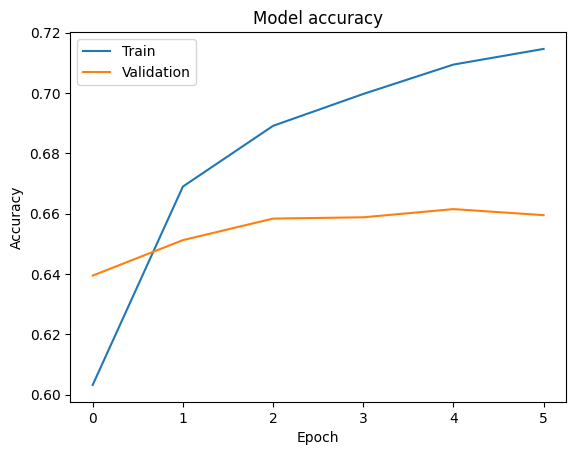

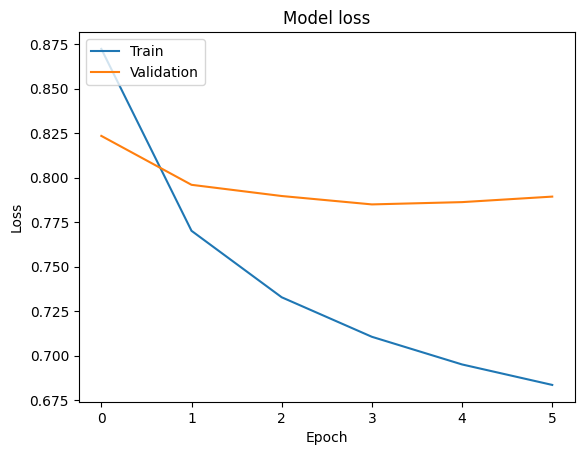

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(snn_model_history.history['accuracy'])
plt.plot(snn_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Convolutional Neural Network

In [33]:
from keras.layers import Conv1D

In [34]:
# # Neural Network architecture

# cnn_model = Sequential()

# embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
# cnn_model.add(embedding_layer)

# cnn_model.add(Conv1D(128, 5, activation='relu'))
# cnn_model.add(GlobalMaxPooling1D())
# cnn_model.add(Dense(1, activation='sigmoid'))


# Define the model
cnn_model = Sequential()

# Embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

# Convolutional layer
cnn_model.add(Conv1D(128, 5, activation='relu'))

# Global max pooling layer
cnn_model.add(GlobalMaxPooling1D())

# Output layer for 3 classes
cnn_model.add(Dense(3, activation='softmax'))  # 3 output units for 3 classes, softmax for multi-class classification

In [35]:
# Model compiling

# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# print(cnn_model.summary())


cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],run_eagerly=True)

# Print model summary
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          26446200  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 26638715 (101.62 MB)
Trainable params: 192515 (752.01 KB)
Non-trainable params: 26446200 (100.88 MB)
_________________________________________________________________
None


In [36]:
# y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (105087, 3)
y_test shape: (26272, 3)


In [37]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 377s 573ms/step - loss: 0.6564 - accuracy: 0.7275 - val_loss: 0.5519 - val_accuracy: 0.7858
Epoch 2/6
657/657 [==============================] - 332s 505ms/step - loss: 0.4530 - accuracy: 0.8339 - val_loss: 0.4727 - val_accuracy: 0.8287
Epoch 3/6
657/657 [==============================] - 335s 509ms/step - loss: 0.3612 - accuracy: 0.8752 - val_loss: 0.4463 - val_accuracy: 0.8390
Epoch 4/6
657/657 [==============================] - 339s 516ms/step - loss: 0.2863 - accuracy: 0.9076 - val_loss: 0.4678 - val_accuracy: 0.8306
Epoch 5/6
657/657 [==============================] - 334s 508ms/step - loss: 0.2256 - accuracy: 0.9316 - val_loss: 0.4621 - val_accuracy: 0.8400
Epoch 6/6
657/657 [==============================] - 333s 506ms/step - loss: 0.1711 - accuracy: 0.9541 - val_loss: 0.4559 - val_accuracy: 0.8445


In [38]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 42s 52ms/step - loss: 0.4437 - accuracy: 0.8465


In [39]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.4437057077884674
Test Accuracy: 0.8465286493301392


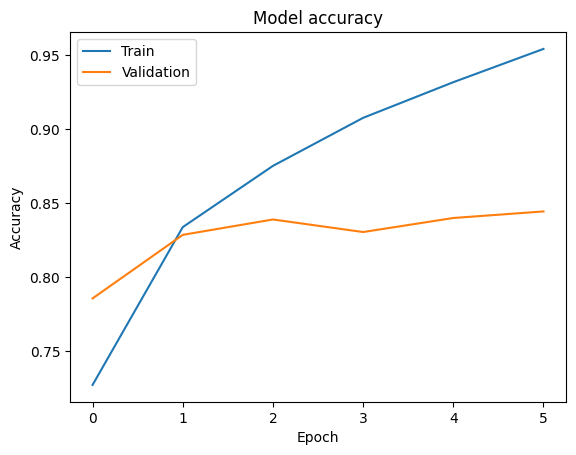

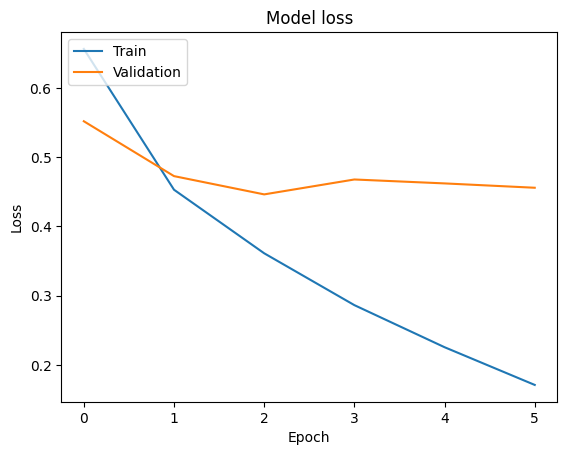

In [40]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(cnn_model_history.history['accuracy'])
plt.plot(cnn_model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Recurrent Neural Network (LSTM)

In [41]:
from keras.layers import LSTM

In [43]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(3, activation='softmax'))

In [44]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          26446200  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 26666235 (101.72 MB)
Trainable params: 220035 (859.51 KB)
Non-trainable params: 26446200 (100.88 MB)
_________________________________________________________________
None


In [45]:
# y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)

# Now print the shapes to verify
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (105087, 3)
y_test shape: (26272, 3)


In [46]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
657/657 [==============================] - 337s 507ms/step - loss: 0.6367 - acc: 0.3410 - val_loss: 0.6384 - val_acc: 0.3297
Epoch 2/6
657/657 [==============================] - 334s 509ms/step - loss: 0.4768 - acc: 0.6340 - val_loss: 0.3982 - val_acc: 0.7322
Epoch 3/6
657/657 [==============================] - 338s 514ms/step - loss: 0.3478 - acc: 0.7753 - val_loss: 0.3351 - val_acc: 0.7863
Epoch 4/6
657/657 [==============================] - 336s 511ms/step - loss: 0.3077 - acc: 0.8072 - val_loss: 0.3059 - val_acc: 0.8124
Epoch 5/6
657/657 [==============================] - 340s 517ms/step - loss: 0.2803 - acc: 0.8304 - val_loss: 0.2846 - val_acc: 0.8303
Epoch 6/6
657/657 [==============================] - 327s 497ms/step - loss: 0.2580 - acc: 0.8476 - val_loss: 0.2659 - val_acc: 0.8430


In [47]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

821/821 [==============================] - 66s 80ms/step - loss: 0.2597 - acc: 0.8452


In [48]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.2597160041332245
Test Accuracy: 0.8451583385467529


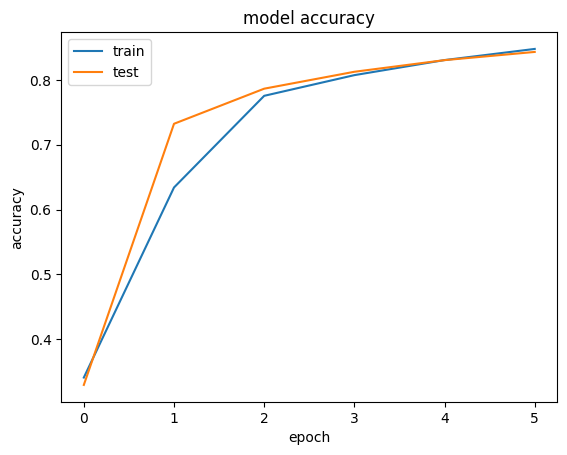

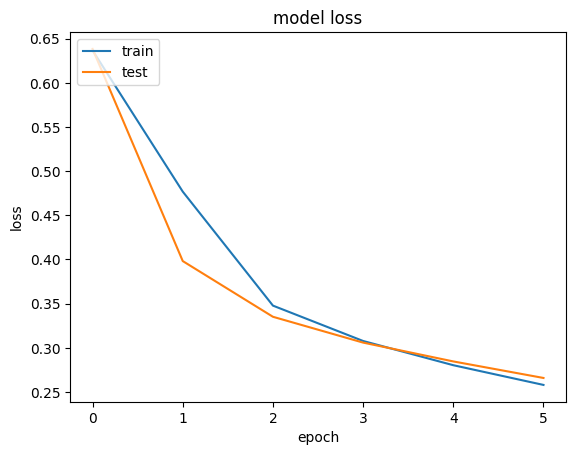

In [49]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()